In [1]:
# use pandas to load data and visualize
# use longformer tokenizer (efficient at tokenizing large texts)
# Set Up the Model for Fine-Tuning (transition to Colab here?)
# Define Training Arguments
from google.colab import drive
drive.mount('/content/drive')
#!pip install -r '/content/drive/My Drive/CS4765 Datasets/requirements.txt'


Mounted at /content/drive


In [1]:
# was having a lot of trouble making the requirements.txt file work in Colab
# so I am manually adding them here as a last resort
# IMPORTANT: If you are using jupyter notebook, please ensure these libraries are installed!
!pip install datasets transformers torch matplotlib seaborn
#!pip install -r '/content/drive/My Drive/CS4765 Datasets/requirements.txt'

zsh:1: command not found: pip


In [10]:
# Visualizing the data with pandasimport pandas as pd
# This cell was used for testing in the colab environment, where we were able to mount our google drive
import pandas as pd
import json

# Ths commented out line below is what was used in the colab environment
# data = pd.read_json('/content/drive/My Drive/CS4765 Datasets/subtaskA_train_monolingual.jsonl', lines=True)

# this line is for running on jupyter notebook, assuming you have the datasets stored in a datasets folder within the root 
data = pd.read_json('./datasets/subtaskA_train_monolingual.jsonl', lines=True) 
print(type(data))
print(data.head())

# visualizing the data, running this slows the computer down a lot because there's a lot of data beware!
# for index, row in data.iterrows():
#     print(f"Row {index}: {row}")



Row 92864: text      The UK parliament is composed of two houses, a...
label                                                     0
model                                                 human
source                                               reddit
id                                                    92864
Name: 92864, dtype: object
Row 92865: text      >  I know that we can say the expression (a/x)...
label                                                     0
model                                                 human
source                                               reddit
id                                                    92865
Name: 92865, dtype: object
Row 92866: text      Why would you want to increase the value of th...
label                                                     0
model                                                 human
source                                               reddit
id                                                    92866
Name: 92866, 

In [12]:
# Some random testing with tokenizer
# # tokenizer function
from transformers import LongformerTokenizer


tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
print(tokenizer("Hello world")["input_ids"])
print(tokenizer('./datasets/subtaskA_dev_monlingual.jsonl')["input_ids"])
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=4096)

/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[0, 31414, 232, 2]
[0, 21594, 36146, 281, 2580, 73, 10936, 45025, 250, 1215, 20068, 1215, 5806, 1527, 5564, 4, 40962, 462, 2]


In [13]:
# Testing the tokenizer on our training dataset
from datasets import Dataset

dataset = Dataset.from_pandas(data)
tokenized_dataset = dataset.map(tokenize_function, batched=True)
print(tokenized_dataset)

Map: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102525/102525 [02:55<00:00, 583.39 examples/s]

Dataset({
    features: ['text', 'label', 'model', 'source', 'id', 'input_ids', 'attention_mask'],
    num_rows: 102525
})


In [14]:
# Testing loading dataset with hugging face library
from datasets import load_dataset

# Loading the dataset from google drive (for colab environment)
# raw_datasets = load_dataset('json',data_files='/content/drive/My Drive/CS4765 Datasets/subtaskA_train_monolingual.jsonl')
# rawvalidation_dataset = load_dataset('json',data_files='/content/drive/My Drive/CS4765 Datasets/validation.jsonl')

# these line below is for running the dataset within jupyter notebook assuming that the dataset is stored in a datasets folder within root directory
raw_datasets = load_dataset('json',data_files='./datasets/subtaskA_train_monolingual.jsonl') # load train set
rawvalidation_dataset = load_dataset('json',data_files='./datasets/validation.jsonl') # load validation set

# Some poking around the raw dataset to see how it got formatted by hugging face data loader
print(raw_datasets['train'][:5])
print(rawvalidation_dataset['train'][:5])
tokenized_subset = raw_datasets["train"].select(range(5)).map(tokenize_function, batched=True)
print(tokenized_subset)

Generating train split: 102525 examples [00:00, 210149.54 examples/s]
Generating train split: 17232 examples [00:00, 307363.61 examples/s]


{'text': ['Forza Motorsport is a popular racing game that provides players with the ability to race on various tracks and in different vehicles. Whether you\'re a seasoned racer or a newbie, playing Forza Motorsport can be a fun experience. In this article, we will take you through the different steps on how to play Forza Motorsport.\n\nStep 1. Insert The Game Disc\n\nThe first step is to insert the game disc into your console or computer. Follow the instructions to set up the game.\n\nStep 2. Choose Your Game\n\nOnce the game is set up, choose the game you\'d like to play. Forza Motorsport has different modes: Career, Free Play, and Arcade. In this article, we will focus on the Arcade mode.\n\nStep 3. Just Make A Quick Race By The Arcade Mode\n\nOnce the Arcade mode is selected, choose "Quick Race" to get started quickly.\n\nStep 4. Pick A Racetrack\n\nPick a racetrack from the different ones available like Road Atlanta, New York, Rio de Janeiro, Maple Valley, or anything to choose fr

Map: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 209.42 examples/s]

Dataset({
    features: ['text', 'label', 'model', 'source', 'id', 'input_ids', 'attention_mask'],
    num_rows: 5
})


In [ ]:
# This cell was supposed to train a longformer model
# We ran into issues with training this model because of how much compute power was necessary
# We tried lowering the max position from 4096 to 2048 but kept timing out
# We also tried running a stronger GPU within Google Colab but were not succesful
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, LongformerConfig, LongformerForSequenceClassification
from datasets import load_dataset
import os

os.environ["WANDB_MODE"] = "disabled"  # Disable wandb mode because it keeps asking for an API key

# Load raw dataset
# Please make sure to adjust the path as needed if you want to try training the longformer
# The path below was for running in a Google Colab environment where my google drive was mounted
# I do not recommend running this on a local machine as it is very resource intensive
raw_datasets = load_dataset('json', data_files='/content/drive/My Drive/CS4765 Datasets/subtaskA_train_monolingual.jsonl')  # For training
# For validation while training, we took about 20% of the train data and put it into a separate file
rawvalidation_dataset = load_dataset('json', data_files='/content/drive/My Drive/CS4765 Datasets/validation.jsonl')

model_name = "allenai/longformer-base-4096"

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=2048)

config = LongformerConfig.from_pretrained(model_name)
config.max_position_embeddings = 2048 # Adjust model configuration for 2048 max position embeddings, to hopefully increase training speed
config.num_labels = 2

model = LongformerForSequenceClassification.from_pretrained(model_name, config=config)

# Tokenize function using Longformer tokenizer
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Tokenize the datasets with above function
tokenized_dataset_train = raw_datasets["train"].map(tokenize_function, batched=True)
tokenized_validation = rawvalidation_dataset["train"].map(tokenize_function, batched=True)

# Define training arguments with default values
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_steps=100,
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    logging_dir="./logs",
    load_best_model_at_end=True,
    log_level="debug",
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_train,
    eval_dataset=tokenized_validation,
)

# Train the model in try catch to make sure we catch silent errors
try:
    trainer.train()  # Add `resume_from_checkpoint=True` if training stops unexpectedly
except Exception as e:
    print(f"Training error: {e}")

# Save the model and tokenizer
print("Saving model...")
model.save_pretrained("./longformer_model")
print("Model saved.")

print("Saving tokenizer...")
tokenizer.save_pretrained("./longformer_model")
print("Tokenizer saved.")


In [3]:
# This cell trains a distilbert model
# the code is very similar to above cell
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import os
import torch


os.environ["WANDB_MODE"] = "disabled"  # Disable wandb mode

# Load raw dataset
# As mentioned before, please adjust the filepath to ther data_files as necessary
raw_datasets = load_dataset('json', data_files='/content/drive/My Drive/CS4765 Datasets/subtaskA_train_monolingual.jsonl')
rawvalidation_dataset = load_dataset('json', data_files='/content/drive/My Drive/CS4765 Datasets/validation.jsonl')

# Load distilbert tokenizer and model
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Tokenize the dataset using DistilBERT tokenizer
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_dataset_train = raw_datasets["train"].map(tokenize_function, batched=True)
tokenized_validation = rawvalidation_dataset["train"].map(tokenize_function, batched=True)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    logging_dir="./logs",
    load_best_model_at_end=True,
    log_level="debug",
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_train,
    eval_dataset=tokenized_validation,
)

# Train the model
try:
    trainer.train()
except Exception as e:
    print(f"Training error: {e}")

# Save it so we don't need to retrain
print("Saving model...")
model.save_pretrained("./distilbert_model")
print("Model saved.")

print("Saving tokenizer...")
tokenizer.save_pretrained("./distilbert_model")
print("Tokenizer saved.")


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/102525 [00:00<?, ? examples/s]

Map:   0%|          | 0/17232 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Currently training with a batch size of: 16
The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, model, source, id. If text, model, source, id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 102,525
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 19,224
  Number of trainable parameters = 66,955,010
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: WARNING The `run_

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,0.060700,3.370243
2,0.027500,4.799409
3,0.007600,5.879086


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, model, source, id. If text, model, source, id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 17232
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-6408
Configuration saved in ./results/checkpoint-6408/config.json
Model weights saved in ./results/checkpoint-6408/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, model, source, id. If text, model, source, id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 17232
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-12816
Confi

Saving model...


Model weights saved in ./distilbert_model/model.safetensors
tokenizer config file saved in ./distilbert_model/tokenizer_config.json
Special tokens file saved in ./distilbert_model/special_tokens_map.json


Model saved.
Saving tokenizer...
Tokenizer saved.


In [15]:
# unzip model, run this to unzip the zipfile of the model
# IMPORTANT: this assumes that the zip file is stored in the root directory
# THIS HAS TO BE RUN FIRST BEFORE RUNNING THE MODEL 
import sys
from zipfile import PyZipFile
pzf = PyZipFile('./distilbert_model.zip')
pzf.extractall()

In [21]:
# If we wnat to reuse the model we trained we can use this code now
# PLEASE MAKE SURE THE ZIP FILE WAS UNZIPPED WITH THE CELL ABOVE
# This cell uses our test data on our fine tuned distilled bert model
# !!THIS CELL TAKES TIME TO RUN!!

from transformers import Trainer, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix, classification_report
from datasets import load_dataset

import seaborn as sns
import torch

# Load the saved model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("./distilbert_model")
tokenizer = AutoTokenizer.from_pretrained("./distilbert_model")

# Load a test dataset
# raw_test_dataset = load_dataset('json', data_files='/content/drive/MyDrive/CS4765 Datasets/subtaskA_dev_monolingual.jsonl')
# Below code is for running in jupyter notebook assuming dataset is inside a datasets folder in root directory
raw_test_dataset = load_dataset('json', data_files='./datasets/subtaskA_dev_monolingual.jsonl')

# Tokenize the test dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_test = raw_test_dataset["train"].map(tokenize_function, batched=True)



# Move model to device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# function to make predictions
def get_predictions(model, dataset):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for example in dataset:
            input_ids = torch.tensor([example["input_ids"]]).to(device)
            attention_mask = torch.tensor([example["attention_mask"]]).to(device)
            label = example["label"]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predicted_label = torch.argmax(logits, dim=1).item()

            predictions.append(predicted_label)
            true_labels.append(label)
    return predictions, true_labels

# Get predictions and true labels
predictions, true_labels = get_predictions(model, tokenized_test)




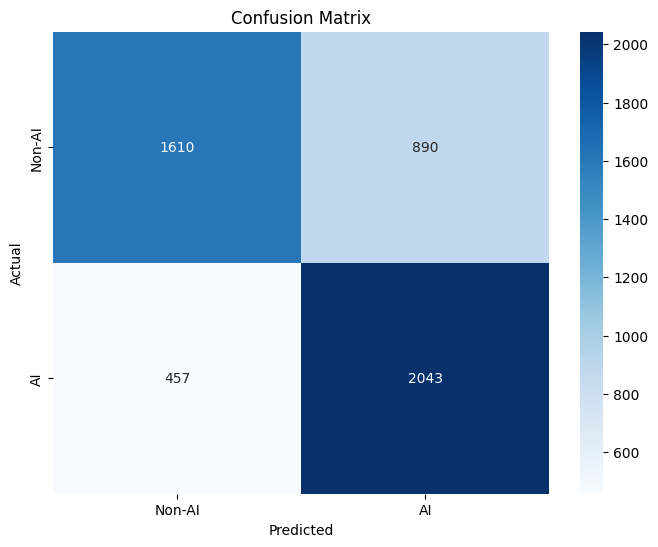

              precision    recall  f1-score   support

      Non-AI       0.78      0.64      0.71      2500
          AI       0.70      0.82      0.75      2500

    accuracy                           0.73      5000
   macro avg       0.74      0.73      0.73      5000
weighted avg       0.74      0.73      0.73      5000



In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Create the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# use matplotlib to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-AI", "AI"], yticklabels=["Non-AI", "AI"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(true_labels, predictions, target_names=["Non-AI", "AI"]))


In [27]:
# We can also use this code for simple testing with one text
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Load the saved model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("./distilbert_model")
tokenizer = AutoTokenizer.from_pretrained("./distilbert_model")



def classifyText(example_text):
    # Tokenize the input
    inputs = tokenizer(example_text, return_tensors="pt", padding="max_length", truncation=True)
    
    # Move tensors to GPU, this line is only relevent for running on Colab
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model.to(device)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    # Perform prediction
    outputs = model(**inputs) # ** automatically unloads a dictionary in python, cool!
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    
    print(f"Predicted Class: {predicted_class}")


In [33]:
# Here are 2 short texts to test against the classifier
# The model is classifying both texts as AI which is wrong. 
# We believe that the length of text is a critical factor for the model to determine if it is AI generated or not
# 1-2 sentences may not be enough for our fine tuned distil bert model to determing if it is AI generated
text1 = "Artificial intelligence is revolutionizing many industries by enabling automation and deeper insights through data analysis."
text2 = "Hello Dr. Cook, I wrote this message myself. I really hope that my classifier doesn't think this was AI"
print('text1 result: ')
classifyText(text1)
print('\ntext2 result: ')
classifyText(text2)

text1 result: 
Predicted Class: 1

text2 result: 
Predicted Class: 1


In [ ]:
# Util cell to export our trained model from colab
from google.colab import files
!zip -r distilbert_model.zip distilbert_model
files.download('distilbert_model.zip')
